# Deep Deterministic Policy Gradient

In [1]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

from dotenv import load_dotenv



load_dotenv()
print(os.getenv('DEVICE'))


None


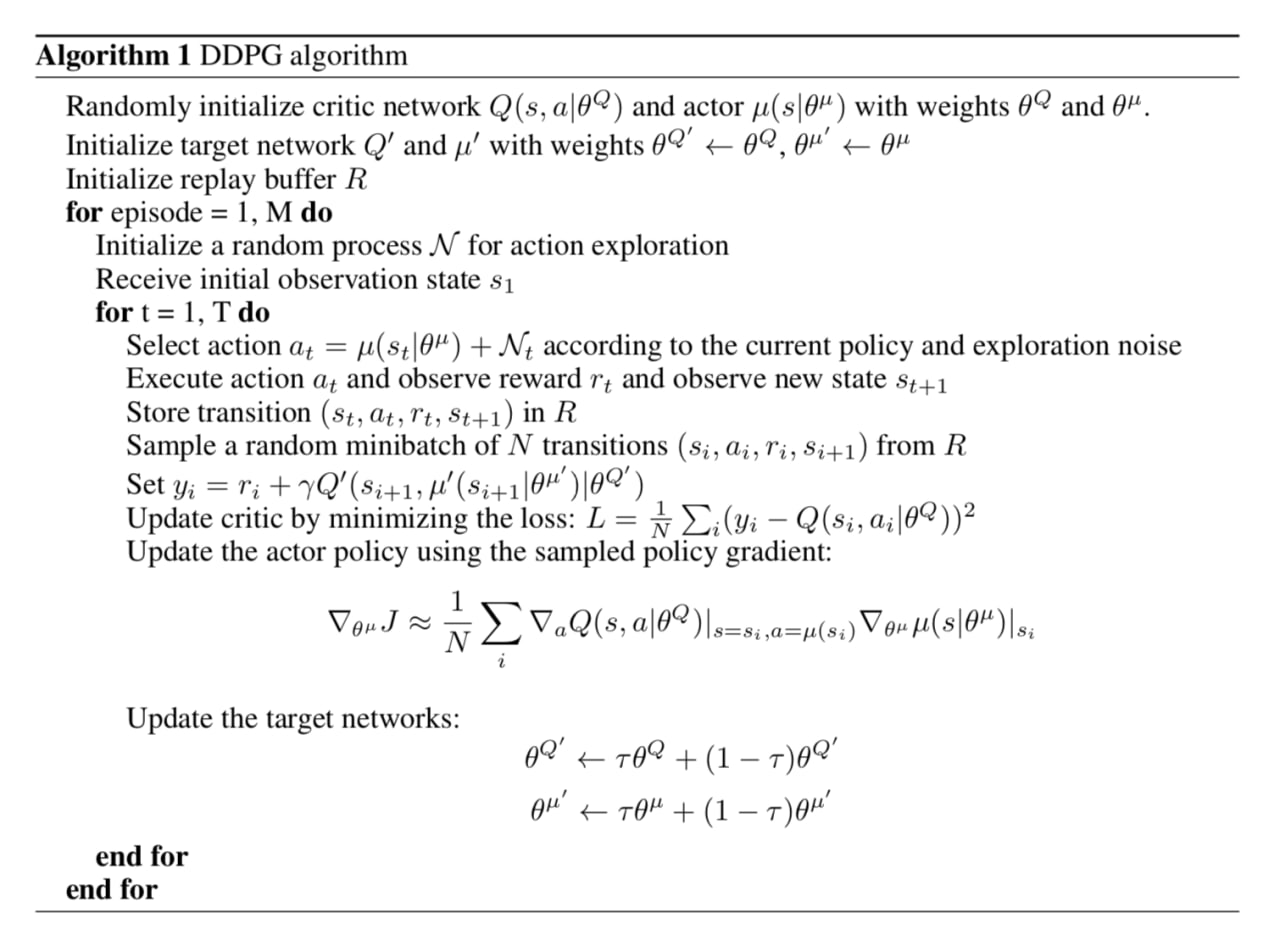

In [11]:

# Ornstein–Uhlenbeck noise for exploration
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [12]:

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        # takes #batchsize random idexes from 0 until maxmem
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [13]:

# Q function approximator
# says how good it was to take action A in state S
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='./models'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg.pth')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        # self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        # self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)

        self.q = nn.Linear(self.fc2_dims, 1)

        # compute the fan-ins for weight initialisation (see DDPG paper)
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1. / np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = "cuda" if T.cuda.is_available() else "cpu"
#         self.device = T.device(os.environ.get('DEVICE'))

        self.to(self.device)

    # TODO: shorten this
    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        # state_value = F.relu(state_value)
        # action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        # TODO: understand why adding and not concatonate?
        # introduce the action values in the second hidden layer (see DDPG paper)
        state_action_value = F.relu(T.add(state_value, action_value))
        # state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')

        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name + '_best.pth')
        T.save(self.state_dict(), checkpoint_file)



In [14]:

# policy approximator
# decides what action to use in current state
# OUTPUTS AN ACTION
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='./models'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg.pth')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        # self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        # self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        # compute the fan-ins for weight initialisation (see DDPG paper)
        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
#         self.device = T.device(os.environ.get('DEVICE'))

        self.to(self.device)

    # TODO: shorten this
    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # we use tanh since lunar lander has action space [-1,1]
        # for other environments with different action spaces just multiply the output
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')

        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name + '_best.pth')
        T.save(self.state_dict(), checkpoint_file)



In [15]:

class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env_id, n_actions, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300,
                 batch_size=64):
        self.algo = "DDPG"
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                  n_actions=n_actions, name=env_id + '_actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name=env_id + '_critic')

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                         n_actions=n_actions, name=env_id + '_target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                           n_actions=n_actions, name=env_id + '_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        # add noise
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = \
            self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        # set Q value of terminal states to 0 (since there will be no future reward)
        critic_value_[done] = 0.0
        # make a list of all critic values (previously it was list of lists)
        critic_value_ = critic_value_.view(-1)

        # y =  r + Q'( s(i+1), U'(s(i+1))
        # --> target = reward + The Q-value (given by target critic) of the action (given by target actor)
        # of the new state
        target = rewards + self.gamma * critic_value_
        # add batch dimension
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        # actor loss : mean of the gradient of the Q value of the action the actor would take
        # minus because gradient ASCENT
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        # soft update the target networks in direction of current networks
        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau * critic_state_dict[name].clone() + \
                                      (1 - tau) * target_critic_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau * actor_state_dict[name].clone() + \
                                     (1 - tau) * target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        # for batchnorm:
        # self.target_critic.load_state_dict(critic_state_dict, strict=False)
        # self.target_actor.load_state_dict(actor_state_dict, strict=False)


In [16]:


def simple_plot(scores, mean_scores, epoch):
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    # plt.ylim(ymin=0)
    plt.text(len(scores) - 1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores) - 1, mean_scores[-1], str(mean_scores[-1]))
    if epoch % 10 == 0:
        plt.show()


def plot_learning_curve(x, scores, figure_file, algo, env_id):

    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i - 100):(i + 1)])
    plt.plot(x, running_avg)
    plt.title(f'{algo} {env_id} avg 100 scores')
    plt.savefig(figure_file)
    plt.close()


In [18]:

# Hyperparams
n_games = 1000
load_checkpoint = False
iterations = 1

env_id = 'LunarLanderContinuous-v2'

env = gym.make(env_id)


def train(iteration):
    filename = agent.algo + "_" + env_id + "_" + str(n_games) + "games" + "_" + str(iteration) + '.png'
    figure_file = 'plots/' + filename

    best_score = env.reward_range[0]
    score_history = []

    if load_checkpoint:
        agent.load_models()
        if os.environ.get('RENDER') == "t":
            env.render(mode='human')

    steps = 0
    for i in range(n_games):
        observation, _ = env.reset()
        done = False
        score = 0

        # for every episode:
        while not done:
            if os.environ.get('RENDER') == "t":
                env.render()

            action = agent.choose_action(observation)
            observation_, reward, done, _,  info = env.step(action[0])
            steps += 1
            agent.remember(observation, action, reward, observation_, done)
            if not load_checkpoint:
                agent.learn()
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print(env_id, "|", 'episode', i, "|", 'score %.1f' % score, "|",
              '100 games avg %.1f' % avg_score, "|",
              'steps %d' % steps, "|"
              )

    if not load_checkpoint:
        x = [i + 1 for i in range(n_games)]
        plot_learning_curve(x, score_history, figure_file, agent.algo, env_id)


for iteration in range(iterations):
    agent = Agent(alpha=0.0001, beta=0.001,
                    input_dims=env.observation_space.shape, tau=0.001, env_id=env_id,
                    batch_size=64, fc1_dims=400, fc2_dims=300,
                    n_actions=env.action_space.shape[0])
    train(iteration + 1)


... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 0 | score -110.5 | 100 games avg -110.5 | steps 78 |
LunarLanderContinuous-v2 | episode 1 | score -539.3 | 100 games avg -324.9 | steps 174 |
LunarLanderContinuous-v2 | episode 2 | score -834.5 | 100 games avg -494.8 | steps 248 |
LunarLanderContinuous-v2 | episode 3 | score -387.6 | 100 games avg -468.0 | steps 330 |
LunarLanderContinuous-v2 | episode 4 | score -740.3 | 100 games avg -522.4 | steps 417 |
LunarLanderContinuous-v2 | episode 5 | score -581.3 | 100 games avg -532.3 | steps 477 |
LunarLanderContinuous-v2 | episode 6 | score -634.9 | 100 games avg -546.9 | steps 554 |
LunarLanderContinuous-v2 | episode 7 | score -324.8 | 100 games avg -519.1 | steps 607 |
LunarLanderContinuous-v2 | episode 8 | score -501.1 | 100 games avg -517.1 | steps 679 |
LunarLanderContinuous-v2 | episode 9 | score -415.9 | 100 games avg -507.0 | steps 735 |
LunarLa

LunarLanderContinuous-v2 | episode 89 | score -129.9 | 100 games avg -234.5 | steps 24585 |
LunarLanderContinuous-v2 | episode 90 | score -59.7 | 100 games avg -232.6 | steps 25230 |
LunarLanderContinuous-v2 | episode 91 | score -30.1 | 100 games avg -230.4 | steps 25731 |
LunarLanderContinuous-v2 | episode 92 | score -171.3 | 100 games avg -229.8 | steps 26238 |
LunarLanderContinuous-v2 | episode 93 | score -353.7 | 100 games avg -231.1 | steps 27200 |
LunarLanderContinuous-v2 | episode 94 | score -272.9 | 100 games avg -231.5 | steps 27457 |
LunarLanderContinuous-v2 | episode 95 | score -545.6 | 100 games avg -234.8 | steps 27593 |
LunarLanderContinuous-v2 | episode 96 | score -206.2 | 100 games avg -234.5 | steps 27998 |
LunarLanderContinuous-v2 | episode 97 | score -488.7 | 100 games avg -237.1 | steps 28140 |
LunarLanderContinuous-v2 | episode 98 | score -161.0 | 100 games avg -236.3 | steps 28352 |
LunarLanderContinuous-v2 | episode 99 | score -192.8 | 100 games avg -235.9 | step

LunarLanderContinuous-v2 | episode 178 | score -634.5 | 100 games avg -182.0 | steps 68491 |
LunarLanderContinuous-v2 | episode 179 | score -158.0 | 100 games avg -182.9 | steps 68603 |
LunarLanderContinuous-v2 | episode 180 | score -167.1 | 100 games avg -183.4 | steps 69279 |
LunarLanderContinuous-v2 | episode 181 | score -43.2 | 100 games avg -182.6 | steps 69839 |
LunarLanderContinuous-v2 | episode 182 | score -107.5 | 100 games avg -182.8 | steps 70648 |
LunarLanderContinuous-v2 | episode 183 | score -285.6 | 100 games avg -185.1 | steps 71912 |
LunarLanderContinuous-v2 | episode 184 | score -164.3 | 100 games avg -186.1 | steps 72374 |
LunarLanderContinuous-v2 | episode 185 | score -295.4 | 100 games avg -188.4 | steps 72499 |
LunarLanderContinuous-v2 | episode 186 | score -555.1 | 100 games avg -192.1 | steps 72622 |
LunarLanderContinuous-v2 | episode 187 | score -284.1 | 100 games avg -194.3 | steps 72757 |
LunarLanderContinuous-v2 | episode 188 | score -370.6 | 100 games avg -

LunarLanderContinuous-v2 | episode 267 | score 129.1 | 100 games avg -135.8 | steps 124187 |
LunarLanderContinuous-v2 | episode 268 | score -359.5 | 100 games avg -137.4 | steps 125489 |
LunarLanderContinuous-v2 | episode 269 | score 136.3 | 100 games avg -134.3 | steps 126386 |
LunarLanderContinuous-v2 | episode 270 | score 103.5 | 100 games avg -130.9 | steps 127219 |
LunarLanderContinuous-v2 | episode 271 | score 93.5 | 100 games avg -127.9 | steps 128086 |
LunarLanderContinuous-v2 | episode 272 | score 188.4 | 100 games avg -124.1 | steps 128669 |
LunarLanderContinuous-v2 | episode 273 | score 176.7 | 100 games avg -123.4 | steps 129778 |
LunarLanderContinuous-v2 | episode 274 | score 230.7 | 100 games avg -122.9 | steps 130317 |
LunarLanderContinuous-v2 | episode 275 | score 159.8 | 100 games avg -117.3 | steps 131244 |
LunarLanderContinuous-v2 | episode 276 | score 190.8 | 100 games avg -113.8 | steps 132065 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpo

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 320 | score -178.6 | 100 games avg -14.5 | steps 165569 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 321 | score 200.1 | 100 games avg -10.8 | steps 166002 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 322 | score 150.7 | 100 games avg -7.7 | steps 166714 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 323 | score 167.6 | 100 games avg -1.4 | steps 167280 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 324 | score 154.4 | 100 games avg 4.2 | steps 167959 |
... saving checkpoint .

LunarLanderContinuous-v2 | episode 373 | score 219.4 | 100 games avg 65.7 | steps 193845 |
LunarLanderContinuous-v2 | episode 374 | score 213.7 | 100 games avg 65.5 | steps 194142 |
LunarLanderContinuous-v2 | episode 375 | score 136.1 | 100 games avg 65.3 | steps 195113 |
LunarLanderContinuous-v2 | episode 376 | score 183.8 | 100 games avg 65.2 | steps 195846 |
LunarLanderContinuous-v2 | episode 377 | score -23.4 | 100 games avg 62.3 | steps 196069 |
LunarLanderContinuous-v2 | episode 378 | score -28.7 | 100 games avg 60.7 | steps 196250 |
LunarLanderContinuous-v2 | episode 379 | score 248.8 | 100 games avg 61.2 | steps 196573 |
LunarLanderContinuous-v2 | episode 380 | score 5.8 | 100 games avg 61.4 | steps 196770 |
LunarLanderContinuous-v2 | episode 381 | score -65.2 | 100 games avg 60.8 | steps 196950 |
LunarLanderContinuous-v2 | episode 382 | score 39.1 | 100 games avg 58.5 | steps 197125 |
LunarLanderContinuous-v2 | episode 383 | score 223.1 | 100 games avg 59.2 | steps 197453 |
Lu

LunarLanderContinuous-v2 | episode 449 | score 251.4 | 100 games avg 80.2 | steps 233686 |
LunarLanderContinuous-v2 | episode 450 | score 225.8 | 100 games avg 84.7 | steps 234057 |
LunarLanderContinuous-v2 | episode 451 | score 15.0 | 100 games avg 82.3 | steps 234273 |
LunarLanderContinuous-v2 | episode 452 | score 253.5 | 100 games avg 84.8 | steps 234887 |
LunarLanderContinuous-v2 | episode 453 | score -173.8 | 100 games avg 80.4 | steps 235013 |
LunarLanderContinuous-v2 | episode 454 | score -19.2 | 100 games avg 83.6 | steps 235180 |
LunarLanderContinuous-v2 | episode 455 | score 294.0 | 100 games avg 84.3 | steps 235544 |
LunarLanderContinuous-v2 | episode 456 | score -177.7 | 100 games avg 81.0 | steps 236525 |
LunarLanderContinuous-v2 | episode 457 | score 242.1 | 100 games avg 81.0 | steps 237029 |
LunarLanderContinuous-v2 | episode 458 | score 204.4 | 100 games avg 88.5 | steps 237374 |
LunarLanderContinuous-v2 | episode 459 | score 157.4 | 100 games avg 87.9 | steps 238346 

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 525 | score 282.8 | 100 games avg 124.5 | steps 267138 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 526 | score 270.7 | 100 games avg 128.4 | steps 267486 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 527 | score 215.0 | 100 games avg 130.5 | steps 267836 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 528 | score 255.9 | 100 games avg 135.0 | steps 268177 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 529 | score 218.0 | 100 games avg 137.9 | steps 268649 |
LunarLanderContinuou

LunarLanderContinuous-v2 | episode 604 | score 148.3 | 100 games avg 129.0 | steps 311514 |
LunarLanderContinuous-v2 | episode 605 | score 204.4 | 100 games avg 128.6 | steps 311917 |
LunarLanderContinuous-v2 | episode 606 | score 242.1 | 100 games avg 133.2 | steps 312196 |
LunarLanderContinuous-v2 | episode 607 | score -22.7 | 100 games avg 133.0 | steps 312425 |
LunarLanderContinuous-v2 | episode 608 | score 278.6 | 100 games avg 133.2 | steps 312720 |
LunarLanderContinuous-v2 | episode 609 | score 201.0 | 100 games avg 133.0 | steps 313376 |
LunarLanderContinuous-v2 | episode 610 | score 208.2 | 100 games avg 132.7 | steps 313748 |
LunarLanderContinuous-v2 | episode 611 | score 269.0 | 100 games avg 132.6 | steps 313991 |
LunarLanderContinuous-v2 | episode 612 | score 72.5 | 100 games avg 130.7 | steps 314203 |
LunarLanderContinuous-v2 | episode 613 | score 245.2 | 100 games avg 130.8 | steps 314598 |
LunarLanderContinuous-v2 | episode 614 | score 56.9 | 100 games avg 129.4 | steps

LunarLanderContinuous-v2 | episode 681 | score -425.2 | 100 games avg 160.0 | steps 349176 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 682 | score 237.0 | 100 games avg 161.9 | steps 349412 |
LunarLanderContinuous-v2 | episode 683 | score 98.5 | 100 games avg 160.2 | steps 350624 |
LunarLanderContinuous-v2 | episode 684 | score -283.4 | 100 games avg 156.9 | steps 351452 |
LunarLanderContinuous-v2 | episode 685 | score 138.0 | 100 games avg 156.3 | steps 352063 |
LunarLanderContinuous-v2 | episode 686 | score -52.5 | 100 games avg 153.4 | steps 352223 |
LunarLanderContinuous-v2 | episode 687 | score 267.8 | 100 games avg 153.4 | steps 352459 |
LunarLanderContinuous-v2 | episode 688 | score 228.4 | 100 games avg 153.3 | steps 352825 |
LunarLanderContinuous-v2 | episode 689 | score 252.9 | 100 games avg 153.7 | steps 353128 |
LunarLanderContinuous-v2 | episode 690 | score 273.9 | 100 games av

LunarLanderContinuous-v2 | episode 768 | score 227.8 | 100 games avg 138.4 | steps 378582 |
LunarLanderContinuous-v2 | episode 769 | score 164.7 | 100 games avg 137.6 | steps 379221 |
LunarLanderContinuous-v2 | episode 770 | score 226.2 | 100 games avg 137.6 | steps 379695 |
LunarLanderContinuous-v2 | episode 771 | score -137.9 | 100 games avg 134.3 | steps 380373 |
LunarLanderContinuous-v2 | episode 772 | score 270.8 | 100 games avg 134.6 | steps 380608 |
LunarLanderContinuous-v2 | episode 773 | score 270.9 | 100 games avg 138.3 | steps 380883 |
LunarLanderContinuous-v2 | episode 774 | score 272.0 | 100 games avg 138.1 | steps 381238 |
LunarLanderContinuous-v2 | episode 775 | score 278.9 | 100 games avg 138.7 | steps 381475 |
LunarLanderContinuous-v2 | episode 776 | score 307.7 | 100 games avg 139.5 | steps 381766 |
LunarLanderContinuous-v2 | episode 777 | score -93.8 | 100 games avg 140.3 | steps 381845 |
LunarLanderContinuous-v2 | episode 778 | score 282.9 | 100 games avg 141.4 | st

LunarLanderContinuous-v2 | episode 845 | score 251.0 | 100 games avg 184.2 | steps 407744 |
LunarLanderContinuous-v2 | episode 846 | score 267.0 | 100 games avg 184.1 | steps 407919 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 847 | score 253.9 | 100 games avg 184.8 | steps 408131 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 848 | score 264.0 | 100 games avg 185.1 | steps 408308 |
LunarLanderContinuous-v2 | episode 849 | score 260.2 | 100 games avg 185.0 | steps 408496 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 850 | score 264.7 | 100 games avg 190.0 | steps 408681 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episo

LunarLanderContinuous-v2 | episode 901 | score 266.3 | 100 games avg 236.1 | steps 424455 |
LunarLanderContinuous-v2 | episode 902 | score 256.1 | 100 games avg 235.9 | steps 424709 |
LunarLanderContinuous-v2 | episode 903 | score 280.1 | 100 games avg 235.7 | steps 424970 |
LunarLanderContinuous-v2 | episode 904 | score 283.4 | 100 games avg 235.9 | steps 425220 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 905 | score 290.7 | 100 games avg 239.1 | steps 425417 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 906 | score 260.9 | 100 games avg 240.8 | steps 425646 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 907 | score 281.3 | 100 games avg 241.4 | steps 425915 |
LunarLanderContinuous-v2 | episode 908 | sco

LunarLanderContinuous-v2 | episode 987 | score 275.2 | 100 games avg 205.6 | steps 448355 |
LunarLanderContinuous-v2 | episode 988 | score 304.0 | 100 games avg 206.5 | steps 448596 |
LunarLanderContinuous-v2 | episode 989 | score -195.2 | 100 games avg 201.8 | steps 449211 |
LunarLanderContinuous-v2 | episode 990 | score -127.5 | 100 games avg 197.6 | steps 449316 |
LunarLanderContinuous-v2 | episode 991 | score 205.8 | 100 games avg 196.9 | steps 449935 |
LunarLanderContinuous-v2 | episode 992 | score 4.2 | 100 games avg 194.3 | steps 450160 |
LunarLanderContinuous-v2 | episode 993 | score 273.1 | 100 games avg 194.1 | steps 450429 |
LunarLanderContinuous-v2 | episode 994 | score 279.0 | 100 games avg 194.2 | steps 450650 |
LunarLanderContinuous-v2 | episode 995 | score 236.1 | 100 games avg 193.9 | steps 450853 |
LunarLanderContinuous-v2 | episode 996 | score 284.7 | 100 games avg 194.1 | steps 451105 |
LunarLanderContinuous-v2 | episode 997 | score 265.5 | 100 games avg 194.2 | ste

KeyboardInterrupt: 

In [20]:
x = [i + 1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file, agent.algo, env_id)

NameError: name 'score_history' is not defined